In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from pettingzoo.classic import texas_holdem_v4
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

import matplotlib.pyplot as plt
import pickle
import os
import imageio


/home/siruwww/6650_final_project/poker/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
class SingleAgentWrapper(gym.Env):
    """Convert PettingZoo Texas Hold'em into single-agent SB3-friendly env."""

    metadata = {"render_modes": ["rgb_array"]}

    def __init__(self):
        super().__init__()
        self.env = texas_holdem_v4.env()
        self.env.reset()

        self.agent = self.env.agents[0]
        
        obs_dict, _, _, _, _ = self.env.last()
        obs = obs_dict["observation"]
        action_mask = obs_dict["action_mask"]

        # OBS space
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=obs.shape, dtype=obs.dtype
        )

        # Action space
        self.action_space = spaces.Discrete(len(action_mask))

        # store mask
        self.last_mask = action_mask

    def reset(self, seed=None, options=None):
        self.env.reset(seed=seed)
        obs_dict, _, _, _, _ = self.env.last()
        self.last_mask = obs_dict["action_mask"]
        return obs_dict["observation"], {}

    def step(self, action):
        # --- Enforce legal action (most important part) ---
        if self.last_mask[action] == 0:
            legal = np.where(self.last_mask == 1)[0]
            action = np.random.choice(legal)

        # Player 0 move
        self.env.step(action)

        # Opponent random move
        opp = self.env.agents[1]
        if not self.env.terminations[opp]:
            obs_dict, _, _, _, _ = self.env.last()
            legal = obs_dict["action_mask"]
            opp_action = np.random.choice(np.where(legal == 1)[0])
            self.env.step(opp_action)

        # Next obs
        obs_dict, reward, terminated, truncated, info = self.env.last()
        self.last_mask = obs_dict["action_mask"]

        return obs_dict["observation"], reward, terminated, truncated, info


### Check Environment

In [3]:
test_env = SingleAgentWrapper()
check_env(test_env, warn=True)
print("Environment OK!")

Environment OK!


### Run Directory Helper

In [4]:
def make_run_dir(base="runs/a2c"):
    os.makedirs("runs", exist_ok=True)
    os.makedirs(base, exist_ok=True)

    run_id = 1
    while os.path.exists(f"{base}_run_{run_id}"):
        run_id += 1

    run_dir = f"{base}_run_{run_id}"
    os.makedirs(run_dir)
    print(f"Created directory: {run_dir}")
    return run_dir


### Evaluation Function

In [5]:
def evaluate(model, episodes=20):
    env_eval = SingleAgentWrapper()
    rewards = []

    for _ in range(episodes):
        obs, _ = env_eval.reset()
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env_eval.step(action)
            total += reward
        rewards.append(total)

    return np.mean(rewards), rewards


In [11]:
import numpy as np
import imageio
from pettingzoo.classic import texas_holdem_v4

def generate_pretty_poker_gif(model=None, path="poker.gif", max_steps=200):
    """
    Generates a high-quality Poker GIF using PettingZoo's renderer.
    If model=None -> random policy
    If model=SB3 model -> use trained policy
    Produces identical visuals to your PPO groupmate's GIF.
    """

    env = texas_holdem_v4.env(render_mode="rgb_array")
    env.reset()

    frames = []
    obs_dict, _, terminated, truncated, _ = env.last()

    step = 0
    while not (terminated or truncated) and step < max_steps:

        # --- High quality rendered frame (THIS is the pretty GUI you want) ---
        frame = env.render()   # RGB array
        frames.append(frame)

        obs = obs_dict["observation"]
        action_mask = obs_dict["action_mask"]

        # Random policy or trained model
        if model is None:
            legal = np.where(action_mask == 1)[0]
            action = np.random.choice(legal)
        else:
            action, _ = model.predict(obs, deterministic=True)
            if action_mask[action] == 0:
                legal = np.where(action_mask == 1)[0]
                action = np.random.choice(legal)

        env.step(action)

        obs_dict, _, terminated, truncated, _ = env.last()
        step += 1

    # Save GIF
    imageio.mimsave(path, frames, fps=2)
    print(f"🎞 GIF saved to {path}")


### Start Training

In [6]:
run_dir = make_run_dir()

env = SingleAgentWrapper()
model = A2C("MlpPolicy", env, verbose=1, learning_rate=7e-4, gamma=0.99)

TIMESTEPS_PER_ITER = 5000
N_ITERS = 40  # 40 * 5000 = 200k steps

reward_history = []

for i in range(N_ITERS):
    model.learn(total_timesteps=TIMESTEPS_PER_ITER, reset_num_timesteps=False)
    mean_r, _ = evaluate(model, episodes=20)
    reward_history.append(mean_r)
    print(f"Iter {i+1}/{N_ITERS} | mean reward = {mean_r:.3f}")

# Save model
model.save(f"{run_dir}/a2c_model.zip")

# Save reward history
with open(f"{run_dir}/reward_history.pkl", "wb") as f:
    pickle.dump(reward_history, f)

print(f"Model + history saved to folder: {run_dir}")


Created directory: runs/a2c_run_1
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1.91     |
|    ep_rew_mean        | 0.09     |
| time/                 |          |
|    fps                | 781      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.35    |
|    explained_variance | 0.0878   |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 3.33     |
|    value_loss         | 13.5     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 2.37     |
|    ep_rew_mean        | 0.115    |
| time/                 |          |
|    fps                | 801      |
|    iterations      

### Plot Training Curve

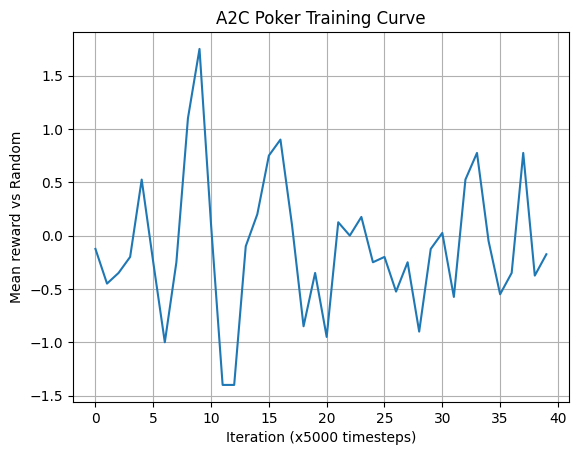

In [7]:
plt.plot(reward_history)
plt.xlabel("Iteration (x5000 timesteps)")
plt.ylabel("Mean reward vs Random")
plt.title("A2C Poker Training Curve")
plt.grid()
plt.savefig(f"{run_dir}/training_curve.png")
plt.show()


In [8]:
# from stable_baselines3 import A2C

# env = SingleAgentWrapper()

# model = A2C(
#     "MlpPolicy",
#     env,
#     verbose=1,
#     learning_rate=7e-4,
#     gamma=0.99,
# )

# model.learn(total_timesteps=200_000)  # 可先跑10万-20万
# model.save("a2c_poker_model")


### Calculate Mean Error

In [9]:
# import numpy as np

# def evaluate(model, episodes=50):
#     env = SingleAgentWrapper()
#     rewards = []
#     for _ in range(episodes):
#         obs, _ = env.reset()
#         done = False
#         total_reward = 0
#         while not done:
#             action, _ = model.predict(obs)
#             obs, reward, done, _, _ = env.step(action)
#             total_reward += reward
#         rewards.append(total_reward)
#     return np.mean(rewards), rewards

# mean_reward, reward_list = evaluate(model, episodes=50)
# mean_reward


### 查看reward分布

In [10]:
# import matplotlib.pyplot as plt

# plt.hist(reward_list, bins=20)
# plt.title("A2C Reward Distribution vs Random Opponent")
# plt.xlabel("Reward")
# plt.ylabel("Frequency")
# plt.show()
